# Part 7
# Author: Georgios Pligoropoulos < george@pligor.com >

In [1]:
# -*- coding: UTF-8 -*-
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
from __future__ import division
from os import path, remove
import numpy as np
import pandas as pd
from csv import QUOTE_ALL
from sklearn.model_selection import StratifiedShuffleSplit
from time import time
from matplotlib import pyplot as plt
import seaborn as sns
import shutil
from sklearn.metrics import r2_score
from collections import OrderedDict
from scipy.spatial.distance import euclidean
from statsmodels.tsa.stattools import coint
from skopt.space.space import Integer, Real
from skopt import gp_minimize
from skopt.plots import plot_convergence
import pickle
import inspect
import dill
import sys
from sklearn.neighbors import NearestNeighbors
from datetime import datetime
import operator
from os.path import isfile, isdir, join
from os import getcwd
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeSVD, MICE, \
    MatrixFactorization, BiScaler
from math import floor
from scipy import stats

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
seed = 16011984
random_state = np.random.RandomState(seed=seed)
n_jobs = 1
%matplotlib inline

In [4]:
from advanced_one_hot_encoder import AdvancedOneHotEncoder

**Short sale** explained: http://www.investopedia.com/terms/r/real-estate-short-sale.asp

## Load Data

In [5]:
twin_cities_path = join(getcwd(), 'twin_cities.csv')
df = pd.read_csv(twin_cities_path, delimiter = ',', encoding='utf-8', quoting=QUOTE_ALL, index_col=0)
df.shape

(1111, 20)

## Drop redundant columns
State column does not hold any information since it is the same for all instances
Also we are dropping last sale date as we are advised to not use it but also because it contains lots of nulls

In [6]:
if 'STATE' in df.columns:
    df = df.drop(labels=['STATE'], axis=1)
if 'LastSaleDate' in df.columns:
    df = df.drop(labels=['LastSaleDate'], axis=1)
df.shape

(1111, 18)

### Keep columns for Price Regression

In [7]:
#Regression Columns
#CITY, ZIP, BEDS, BATHS, SQFT, LotSize, YearBuilt, ParkingSpots, HasGarage, LATITUDE, LONGITUDE, ShortSale
XX = df[
    ['CITY', 'ZIP', 'BEDS', 'BATHS', 'SQFT', 'LotSize', 'YearBuilt', 'ParkingSpots', 'HasGarage', 'LATITUDE',
     'LONGITUDE', 'ShortSale']
]
XX.shape

(1111, 12)

In [8]:
#target: ListPrice
yy = df['ListPrice']
yy.shape

(1111,)

### Numerify data

In [9]:
if XX['BATHS'].dtype == 'object':
    XX['BATHS'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['BATHS']]
XX['BATHS'].dtype

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


dtype('float64')

#### CITY

In [10]:
print len(XX['CITY'].unique())
XX['CITY'].unique()

6


array([u'St. Paul', u'Shoreview', u'Minneapolis', u'Woodbury',
       u'West St. Paul', u'Maplewood'], dtype=object)

In [11]:
if 'CITY' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='CITY')
XX.shape

(1111, 16)

#### ZIP

In [12]:
#comparing locations and zips lengths
print len(df['LOCATION'].unique())
print len(df['ZIP'].unique())

86
33


In [13]:
if 'ZIP' in XX.columns:
    XX = AdvancedOneHotEncoder().encodePandasColAndMerge(data_frame=XX, col_name='ZIP')
XX.shape

(1111, 47)

#### Year Built to Age

In [14]:
if 'YearBuilt' in XX.columns:
    XX['age'] = 2014 - XX['YearBuilt']
    XX.drop(labels='YearBuilt', axis=1, inplace=True)
assert 'age' in XX.columns
XX.shape

(1111, 47)

#### Has Garage to binary

In [15]:
XX['HasGarage'].unique()

array([u'Garage', u'No Garage'], dtype=object)

In [16]:
if 'Garage' in XX['HasGarage'].unique():
    XX['HasGarage'] = XX['HasGarage'] == 'Garage'
XX['HasGarage'].unique()

array([True, False], dtype=object)

#### Short Sale to binary

In [17]:
XX['ShortSale'].unique()

array([u'N', u'Y'], dtype=object)

In [18]:
if 'Y' in XX['ShortSale'].unique():
    XX['ShortSale'] = XX['ShortSale'] == 'Y'
XX['ShortSale'].unique()

array([False, True], dtype=object)

#### Latitude

In [19]:
if XX['LATITUDE'].dtype == 'object':
    XX['LATITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LATITUDE']]
XX['LATITUDE'].dtype

dtype('float64')

#### Longitude

In [20]:
if XX['LONGITUDE'].dtype == 'object':
    XX['LONGITUDE'] = [float(coord.replace(',', '.')) if isinstance(coord, basestring) else float(coord)
            for coord in XX['LONGITUDE']]
XX['LONGITUDE'].dtype

dtype('float64')

### Fill the Gaps
Rule of thumb of KNN to pick a neighborhood of 1%

In [21]:
k_factor = int(floor(len(XX) * 0.01))
k_factor

11

In [22]:
if sum(XX.isnull().sum()) > 0:
    XX[XX.columns] = KNN(k=k_factor).complete(XX.values)

Imputing row 1/1111 with 0 missing, elapsed time: 0.429
Imputing row 101/1111 with 1 missing, elapsed time: 0.444
Imputing row 201/1111 with 1 missing, elapsed time: 0.445
Imputing row 301/1111 with 0 missing, elapsed time: 0.446
Imputing row 401/1111 with 0 missing, elapsed time: 0.447
Imputing row 501/1111 with 0 missing, elapsed time: 0.447
Imputing row 601/1111 with 0 missing, elapsed time: 0.448
Imputing row 701/1111 with 0 missing, elapsed time: 0.449
Imputing row 801/1111 with 0 missing, elapsed time: 0.449
Imputing row 901/1111 with 0 missing, elapsed time: 0.450
Imputing row 1001/1111 with 0 missing, elapsed time: 0.450
Imputing row 1101/1111 with 0 missing, elapsed time: 0.451


In [23]:
sum(XX.isnull().sum())

0

# Question 7
You’ve just been hired as a data scientist at the premier real estate firm in this area.
They want to forecast the actual sales price for any of these listings (and future listings).

What variables from this example data do you think would be the most predictive of the
actual sales price? What other kinds of data would you want have to provide the most
accurate prediction of the actual sales price?

Assume you can get any data you want. Describe this data clearly and why you think it
would help you build an accurate predictive model.

### Answer

In [24]:
print "which columns we have NOT included for training"
set(df.columns).difference(XX.columns)

which columns we have NOT included for training


{u'ADDRESS',
 u'CITY',
 u'DOM',
 u'LOCATION',
 u'ListPrice',
 u'Realty',
 u'SoldPrev',
 u'YearBuilt',
 u'ZIP'}

Let's give an explanation why according to our domain knowledge we have excluded these infomation:

- Address is the name of street, and sometimes this could be useful since houses in the same road tend to have similar prices but we have to experiment with various preprocessing steps which we cannot afford to do in the time scope of this exercise

- City has been one-hot encoded

- Days On the Market is information of how long a house is for sale. This could be an indicator of the price but because houses do not lose value proportionally to the days that they are for sale, we consider it to play a small role.

- Location is yet another categorization of the area. We are going to let the zip codes provide organizational information around the price of an area

- ListPrice is the targe

- Realty is just the name of the real estate company, no useful info in there

- Sold Previously is an indication if it is a second hand house or not but again it is not like it is a second hand car. The house still maintains its value.

- YearBuilt has been converted to Age

- ZIP has been one hot encoded

#### train test split

In [25]:
# uniqueValuesPerCol = OrderedDict()
# for col in XX.columns:
#     uniqueValuesPerCol[col] = len(XX[col].unique())
# pd.DataFrame(index=uniqueValuesPerCol.keys(), data={"unique values per column": uniqueValuesPerCol.values()}
#             ).sort_values(by="unique values per column", ascending=False)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(XX, yy, train_size = 0.8, test_size=0.2,
                                                    random_state=random_state)

### Decision Tree

In [27]:
from sklearn.tree import DecisionTreeRegressor

In [28]:
dtr = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                           #max_depth=max_depth, #this is a hyperparameter
                            presort = True, #to speed up the finding of best splits when fitting
                           )

In [29]:
dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=True, random_state=None,
           splitter='best')

In [30]:
def getCV(max_depth, cv=10):
    estimator = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                           max_depth=max_depth, #this is a hyperparameter
                            presort = True, #to speed up the finding of best splits when fitting
                           )
    return np.mean(cross_val_score(estimator=estimator, X=X_train, y=y_train, cv=cv))

In [31]:
%%time
scores = OrderedDict()
best_param = None
best_score = float('-inf')
for max_depth in range(1, 35):
    cur_score = getCV(max_depth)
    scores[max_depth] = cur_score
    if  cur_score > best_score:
        best_score = cur_score
        best_param = max_depth

CPU times: user 31.7 s, sys: 1.79 s, total: 33.5 s
Wall time: 37 s


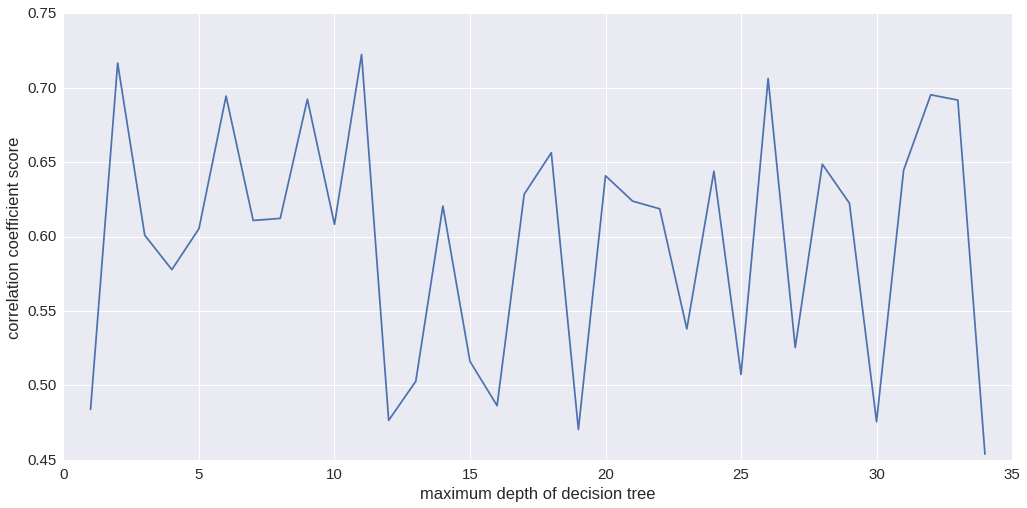

In [32]:
sns.set(font_scale=1.5)
plt.figure(figsize=(17,8))
plt.plot(scores.keys(), scores.values())
plt.ylabel('correlation coefficient score')
plt.xlabel('maximum depth of decision tree')
plt.show()

We notice that we have a large variance on the results when choosing the various maximum depths of the decision tree

Therefore we are going to pick the simplest model that is within one standard deviation from the best score

In [33]:
best_score

0.72244563254522642

In [34]:
score_std = np.std(scores.values())
score_std

0.08027142179665514

In [35]:
threshold_score = best_score - score_std
threshold_score

0.64217421074857128

In [36]:
score_series = pd.Series(index=scores.keys(), data=scores.values())
score_series.sample()

31    0.644663
dtype: float64

In [37]:
print "maximum decision tree depths which are within one std from the best score"
good_depths = sorted(score_series[score_series >= threshold_score].index)
good_depths

maximum decision tree depths which are within one std from the best score


[2, 6, 9, 11, 18, 24, 26, 28, 31, 32, 33]

We'll just pick any of these values and we choose to pick maximum depth of 7

In [38]:
selected_max_depth = 7

### Testing generalization performance
Let's test the generalization performance on all of them

In [39]:
%%time
scores = OrderedDict()
best_param = None
best_score = float('-inf')
for max_depth in good_depths:
    cur_score = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                           max_depth=max_depth, #this is a hyperparameter
                            presort = True, #to speed up the finding of best splits when fitting
                           ).fit(X_train, y_train).score(X_test, y_test)
    scores[max_depth] = cur_score
    if  cur_score > best_score:
        best_score = cur_score
        best_param = max_depth

CPU times: user 1.24 s, sys: 172 ms, total: 1.42 s
Wall time: 1.76 s


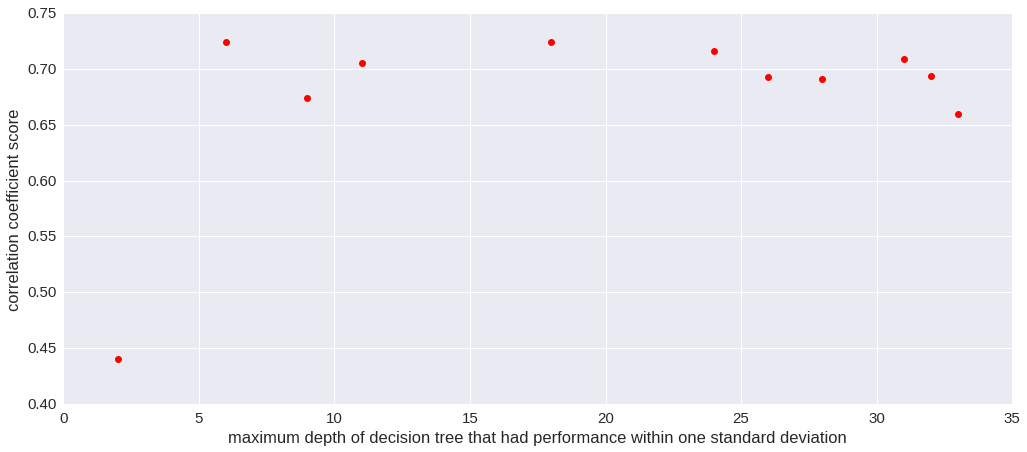

In [40]:
plt.figure(figsize=(17,7))
plt.plot(scores.keys(), scores.values(), 'ro')
plt.xlabel('maximum depth of decision tree that had performance within one standard deviation')
plt.ylabel('correlation coefficient score')
plt.show()

In [41]:
best_param

6

Note that we are here it seems to be doing something that it is NOT correct, we are selecting the max depth hyperparameter by checking on the test set!!! Not correct!

No, actually we are just confirming that a simpler model has much better chances of generalizing and on the same time we should not make it too simple. The selected max depth above is indeed the best maximum depth for the testing set. Awesome! let's train for this depth the entire dataset

In [42]:
selected_max_depth

7

In [43]:
estimator = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                           max_depth=selected_max_depth, #this is a hyperparameter
                            presort = True, #to speed up the finding of best splits when fitting
                           ).fit(X_train, y_train)
estimator.score(X_test, y_test)

0.72852996251460866

In [44]:
dt = DecisionTreeRegressor(criterion='mae', #because it is more tolerant against outliers
                           max_depth=selected_max_depth, #this is a hyperparameter
                            presort = True, #to speed up the finding of best splits when fitting
                           ).fit(XX, yy)
print "total number of features when fit is performed"
dt.n_features_

total number of features when fit is performed


47

### Visualize the decision tree
Decision trees are interpretable by humans

In [45]:
from sklearn import tree
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

In [46]:
with open("real_estate_tree.dot", 'w') as fp:
    f = export_graphviz(estimator, out_file=fp,
                        feature_names=XX.columns,
                        filled=True,
                        rounded=True,  
                        special_characters=True)

You need Xdot in Linux to open the file and observe the tree by double clicking the file: real_estate_tree.dot

Alternatively there is this online viewer: http://dreampuf.github.io/GraphvizOnline/

### Importance of features

In [46]:
featureImportances = OrderedDict()

arrayFeatureImportances = dt.feature_importances_

counter = 0
for col in XX.columns:
    featureImportances[col] = arrayFeatureImportances[counter]
    counter += 1
    
featureImportances = pd.Series(index=featureImportances.keys(), data=featureImportances.values())
featureImportances.shape

(47,)

In [47]:
print "these are the 10 most important features:"
featureImportances.sort_values(ascending=False)[:10]

these are the 10 most important features:


SQFT            0.562970
LONGITUDE       0.135728
LATITUDE        0.134907
age             0.054118
LotSize         0.039302
ParkingSpots    0.019699
BATHS           0.018733
ZIP_28          0.006325
ZIP_19          0.005756
ZIP_6           0.004601
dtype: float64

10 most important Features (Gini):
SQFT: 0.563189
Latitude: 0.133847
Longitude: 0.130789
Age: 0.058908
Lot Size: 0.041424
Bedrooms: 0.018911
Bathrooms: 0.011640
Parking Spots: 0.011396
Zip Code is 55410 or not: 0.006582
Zip Code is 55405 or not: 0.006325

## Second sub question
What other kinds of data would you want have to provide the most
accurate prediction of the actual sales price?

Assume you can get any data you want. Describe this data clearly and why you think it
would help you build an accurate predictive model.

### Answer to second sub question
Data which are missing could be:

- **floors** of the house, because a flat apartment is perceived of lower value in comparison to the same sqft in multiple floors
- **swimming pool**, for obvious reasons
- Any metrics of the **condition** of the house in case it has been more or less taken care of (need of painting etc.)
- The year that it was **renovated** which should have a high correlation with the condition
- Is it built to withstand **earthquakes**? This could be a binary value based on whether it was built
- Whether is has a **view** or not. If all you can see is the building across the street then the view is not good
- **Energy efficiency** is paramount these days. It could lower or increase the heating bills
- Does it include **solar panels** ?

All of the above are related with the value of the house



In our dataset we have the Days on the market (DOM) which is not giving much of information by itself

We would like to have all the dates of when a house was actually sold and have those for all the houses. This way we could create a histogram of how often a house that is DOM days on the market gets sold. This could give us an average per area and this way we would know that houses that are too long in the market are for some bizarre reason not sell-able at the moment and thus avoid dealing with them or know that a house that is for some days in the market has a high chance of being sold soon and thus we should act quickly.

In other words we are including a second task where we need to determine if the recent (could be years) history of house sales determines the probability of a house being sold in one day, one week or one month from now. For machine learning and big data this could simply be a classification task